## Initial Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.kinetics import Kinetics400
from IPython.display import Video

Path.ls = lambda x: [o.name for o in x.iterdir()]

### Video Transformations from [`pytorch/vision/references/video_classification/transforms.py` ](https://github.com/pytorch/vision/blob/master/references/video_classification/transforms.py)

In [2]:
import torch
import random


def crop(vid, i, j, h, w):
    return vid[..., i:(i + h), j:(j + w)]


def center_crop(vid, output_size):
    h, w = vid.shape[-2:]
    th, tw = output_size

    i = int(round((h - th) / 2.))
    j = int(round((w - tw) / 2.))
    return crop(vid, i, j, th, tw)


def hflip(vid):
    return vid.flip(dims=(-1,))


# NOTE: for those functions, which generally expect mini-batches, we keep them
# as non-minibatch so that they are applied as if they were 4d (thus image).
# this way, we only apply the transformation in the spatial domain
def resize(vid, size, interpolation='bilinear'):
    # NOTE: using bilinear interpolation because we don't work on minibatches
    # at this level
    scale = None
    if isinstance(size, int):
        scale = float(size) / min(vid.shape[-2:])
        size = None
    return torch.nn.functional.interpolate(
        vid, size=size, scale_factor=scale, mode=interpolation, align_corners=False)


def pad(vid, padding, fill=0, padding_mode="constant"):
    # NOTE: don't want to pad on temporal dimension, so let as non-batch
    # (4d) before padding. This works as expected
    return torch.nn.functional.pad(vid, padding, value=fill, mode=padding_mode)


def to_normalized_float_tensor(vid):
    return vid.permute(3, 0, 1, 2).to(torch.float32) / 255


def normalize(vid, mean, std):
    shape = (-1,) + (1,) * (vid.dim() - 1)
    mean = torch.as_tensor(mean).reshape(shape)
    std = torch.as_tensor(std).reshape(shape)
    return (vid - mean) / std


# Class interface

class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    @staticmethod
    def get_params(vid, output_size):
        """Get parameters for ``crop`` for a random crop.
        """
        h, w = vid.shape[-2:]
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w
        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, vid):
        i, j, h, w = self.get_params(vid, self.size)
        return crop(vid, i, j, h, w)


class CenterCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, vid):
        return center_crop(vid, self.size)


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, vid):
        return resize(vid, self.size)


class ToFloatTensorInZeroOne(object):
    def __call__(self, vid):
        return to_normalized_float_tensor(vid)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, vid):
        return normalize(vid, self.mean, self.std)


class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, vid):
        if random.random() < self.p:
            return hflip(vid)
        return vid


class Pad(object):
    def __init__(self, padding, fill=0):
        self.padding = padding
        self.fill = fill

    def __call__(self, vid):
        return pad(vid, self.padding, self.fill)


### .

## Data Loading

In [3]:
base_dir = Path('/Users/rahulsomani/01_github_projects/video-classification/')
data_dir = base_dir/'data'

In [4]:
!tree {data_dir/'train'}

/Users/rahulsomani/01_github_projects/video-classification/data/train
├── class1
│   ├── c1-sample1.mp4
│   └── c1-sample2.mp4
└── class2
    ├── c2-sample1.mp4
    └── c2-sample2.mp4

2 directories, 4 files


In [5]:
data = Kinetics400(data_dir/'train',
                   step_between_clips = 1,
                   extensions         = ('mp4',),
                   frames_per_clip    = 32,
                   frame_rate = None)

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


## Seeing the Data to Understand What Exactly is in the Training Data

### Helper Functions

In [6]:
def get_metadata(data):
    """
    Takes in a `Kinetics400` dataset, computes the no. of frames in each data point
    and returns in a DataFrame
    """
    fnames     = [f.rsplit('/')[-1] for f in data.metadata['video_paths']]
    num_frames = [len(pts) for pts in data.metadata['video_pts']]
    fps        = [i for i in data.metadata['video_fps']]

    metadata = pd.DataFrame(list(zip(fnames, num_frames, fps)), columns = ['Filename', '# Frames', 'FPS'])
    return metadata

In [7]:
def plot_img(sub_plt, x, i):
    """
    Where `x` is one data sample of shape `(T, H, W, C)` and
    `i` is the index of `T` that must be plotted.
    `sub_plt` is an `AxesSubplot`.
    This function removes axes labels and ticks, and names the
    subplot with the appropriate frame number
    """
    sub_plt.imshow(x[i])
    sub_plt.set_title(f'Frame #{i+1}')
    sub_plt.axis('off')

In [8]:
def plot_adjacent(x):
    f, plots = plt.subplots(1, 2, figsize=(8, 5))
    plots[0] = plot_img(plots[0], x, 0)
    plots[1] = plot_img(plots[1], x, 31)

    f.tight_layout()

### Seeing the Training Data

<br>
When the dataset of class `Kinetics400` is constructed with `frames_per_clip = 32`, it doesn't take into consideration any data points which have less than 32 clips. <br>

As seen in the DataFrame above, `c2-sample1` and `c2-sample2` had less than 32 frames, and `[len(x) for x in data.video_clips.clips]` reveals that 0 samples were taken from both these clips. 

For `c1-sample1`, which has exactly 32 clips, one clip gets created, whereas for `c1-sample2`, 16 clips get created, leading to a dataset of `len = 17`. The dataset has 1 sample from `c1-sample1` and 16 samples from `c1-sample2`.

<br>

In [9]:
get_metadata(data)

,Filename,# Frames,FPS
0,c1-sample1.mp4,32,25.0
1,c1-sample2.mp4,47,25.0
2,c2-sample1.mp4,17,25.0
3,c2-sample2.mp4,13,25.0


In [10]:
len(data)

17

In [11]:
[len(x) for x in data.video_clips.clips]

[1, 16, 0, 0]

---
<h3> Below are the actual videos

In [12]:
Video('../data/train/class1/c1-sample1.mp4', width=400)

In [13]:
Video('../data/train/class1/c1-sample2.mp4', width=400)

In [14]:
Video('../data/train/class2/c2-sample1.mp4', width=400)

In [15]:
Video('../data/train/class2/c2-sample2.mp4', width=400)

<br>

To fully understand what's happening, look at the first and last frames of selected data samples (indices 0, 1, 2 and 16) below.

<br>

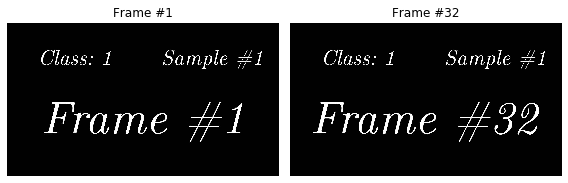

In [17]:
plot_adjacent(data[0][0])

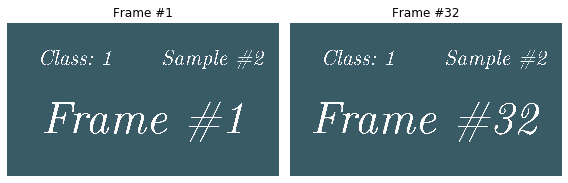

In [18]:
plot_adjacent(data[1][0])

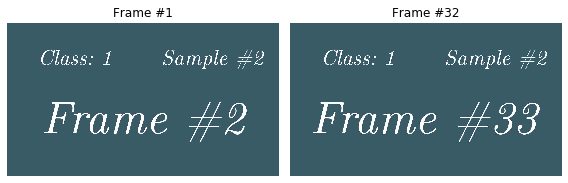

In [19]:
plot_adjacent(data[2][0])

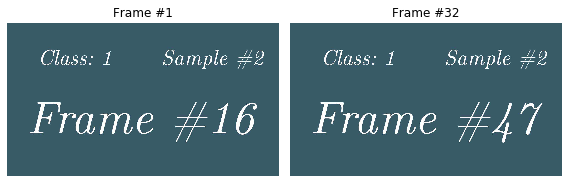

In [20]:
plot_adjacent(data[16][0])

<br>

---

## Figuring out by Experimenting

In [21]:
from torchvision.datasets.video_utils import *

In [22]:
x_pts = data.video_clips.video_pts[1]
x_pts

tensor([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
        10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000,
        20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000,
        30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000,
        40000, 41000, 42000, 43000, 44000, 45000, 46000])

In [53]:
x_fps = data.video_clips.video_fps[1]
x_fps

25.0

In [54]:
fr = data.video_clips.frame_rate
fr

In [108]:
clips, idxs = VideoClips.compute_clips_for_video(
    video_pts  = x_pts,
    num_frames = 16,
    step = 1,
    fps  = x_fps,
    frame_rate = fr)

In [110]:
len(clips)

32

In [ ]:
tmp = [len(v) for v in clips]
tmp

In [50]:
torch.as_tensor(tmp).cumsum(0).tolist()

[32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512]

In [35]:
data.video_clips.cumulative_sizes

[1, 17, 17, 17]

In [67]:
data.video_clips.clips

[tensor([[    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
          10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000,
          20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000,
          30000, 31000]]),
 tensor([[    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
          10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000,
          20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000,
          30000, 31000],
         [ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000, 10000,
          11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000,
          21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000,
          31000, 32000],
         [ 2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000, 10000, 11000,
          12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000,
          22000, 23000, 24000, 25000, 26000

In [66]:
torch.as_tensor([len(v) for v in data.video_clips.clips])

tensor([ 1, 16,  0,  0])

In [38]:
import matplotlib.pyplot as plt

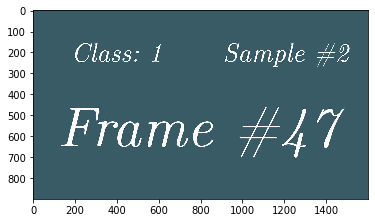

In [96]:
plt.imshow(data[16][0][31])

In [79]:
data[0][2]

0